In [1]:
!pip install hazm

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 892.6/892.6 kB 20.3 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 94.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 87.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 49.7 MB/s eta 0:00:00:00:0100:01
  Created wheel for flashtext: filename=flashtext-2.7-py2.py3-none-any.whl size=9296 sha256=6409cfb8256647aea41277e645aa532e6eed565b58ce8d4a5905baf136572c7c
  Stored in directory: /root/.cache/pip/wheels/bc/be/39/c37ad168eb2ff644c9685f52554440372129450f0b8ed203dd
Successfully built flashtext
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uni

In [2]:
import pandas as pd
import re
from hazm import Normalizer, stopwords_list, word_tokenize
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [4]:
df = pd.read_csv("/kaggle/input/persian-spam-email/emails.csv")

In [5]:
df.shape

(1000, 2)

In [6]:
df.head()

,text,label
0,﻿ممنون آقا سامان.\nمن پارسال اصلا آزاد شرکت نک...,ham
1,﻿سلام آقای کریمی\nبالاخره آزمونارشد تموم شد من...,ham
2,﻿درود بر حاج وحیدی بنده بعنوان یک دکتری تاریخ ...,ham
3,﻿با سلام و احترام\nضمن تقدیر از مسولین محترم ...,ham
4,﻿با سلام اینجانب یک دستگاه خودرو پراید 131 با ...,ham


In [7]:
print("\nLabel Distribution:")
print(df['label'].value_counts())


Label Distribution:
label
ham     500
spam    500
Name: count, dtype: int64


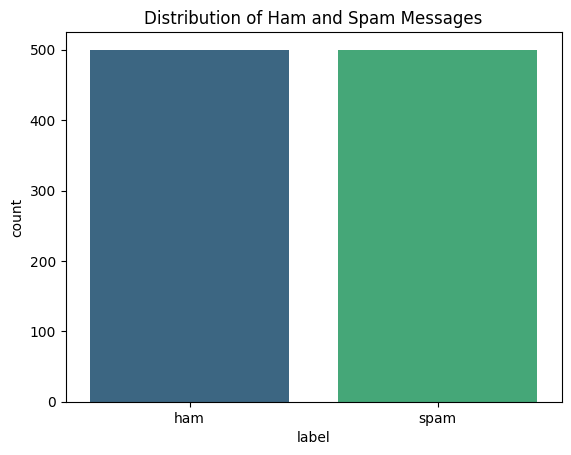

In [8]:
sns.countplot(data=df, x='label', palette='viridis')
plt.title("Distribution of Ham and Spam Messages")
plt.show()

In [9]:
normalizer = Normalizer()
stopwords = set(stopwords_list())

In [10]:
def preprocess_text(text):
    # Normalize text
    text = normalizer.normalize(text)
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove email addresses
    text = re.sub(r'\S+@\S+\.\S+', '', text)
    # Remove phone numbers (any sequence of 7+ digits)
    text = re.sub(r'\b\d{7,}\b', '', text)
    # Reduce repeated characters (e.g., ععععلی → علی)
    text = re.sub(r'(\w)\1{2,}', r'\1', text)
    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords]
    return ' '.join(tokens)

In [11]:
df['cleaned_text'] = df['text'].apply(preprocess_text)

In [12]:
df.head()

,text,label,cleaned_text
0,﻿ممنون آقا سامان.\nمن پارسال اصلا آزاد شرکت نک...,ham,﻿ممنون آقا سامان . پارسال اصلا آزاد شرکت نکرده...
1,﻿سلام آقای کریمی\nبالاخره آزمونارشد تموم شد من...,ham,﻿سلام کریمی بالاخره آزمونارشد تموم راحت شدم یک...
2,﻿درود بر حاج وحیدی بنده بعنوان یک دکتری تاریخ ...,ham,﻿درود حاج وحیدی بنده بعنوان دکتری تاریخ دستی ت...
3,﻿با سلام و احترام\nضمن تقدیر از مسولین محترم ...,ham,﻿با سلام احترام تقدیر مسولین محترم سایت تابناک...
4,﻿با سلام اینجانب یک دستگاه خودرو پراید 131 با ...,ham,﻿با سلام اینجانب دستگاه خودرو پراید ۱۳۱ شماره ...


In [15]:
def tokenize_text(tokenizer, text, max_length=32):
    tokens = tokenizer.encode_plus(
        text,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )
    return tokens['input_ids'].squeeze(0)

def get_embeddings(text, max_length=32):
    tokens = tokenizer.encode_plus(
        text,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    )
    input_ids = tokens['input_ids']
    attention_mask = tokens['attention_mask']

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    cls_embedding = outputs.last_hidden_state[:, 0, :]
    return cls_embedding.squeeze(0).cpu().numpy()


In [16]:
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")
df['tokenized'] = df['cleaned_text'].apply(lambda x: tokenize_text(tokenizer, x).tolist())

model = AutoModel.from_pretrained("HooshvareLab/bert-fa-base-uncased")
df['embeddings'] = df['cleaned_text'].apply(get_embeddings)

embeddings = df['embeddings'].tolist()
pca = PCA(n_components=120)
reduced_embeddings = pca.fit_transform(embeddings)

df['reduced_embeddings'] = list(reduced_embeddings)

In [17]:
df.to_csv("preprocessed_data.csv")

In [18]:
df = pd.read_csv("/kaggle/working/preprocessed_data.csv")

In [19]:
df.head()

,Unnamed: 0,text,label,cleaned_text,tokenized,embeddings,reduced_embeddings
0,0,﻿ممنون آقا سامان.\nمن پارسال اصلا آزاد شرکت نک...,ham,﻿ممنون آقا سامان . پارسال اصلا آزاد شرکت نکرده...,"[2, 25303, 7664, 9819, 1012, 14104, 5899, 3912...",[ 2.03596130e-01 -6.73360646e-01 1.99428499e+...,[ 1.22374149e+01 -2.53756607e+00 -4.00591262e+...
1,1,﻿سلام آقای کریمی\nبالاخره آزمونارشد تموم شد من...,ham,﻿سلام کریمی بالاخره آزمونارشد تموم راحت شدم یک...,"[2, 4285, 10407, 7637, 6191, 42075, 31920, 630...",[ 4.62497562e-01 6.67644739e-01 1.88398123e+...,[ 7.17889295e+00 -2.17502630e+00 5.07199329e-...
2,2,﻿درود بر حاج وحیدی بنده بعنوان یک دکتری تاریخ ...,ham,﻿درود حاج وحیدی بنده بعنوان دکتری تاریخ دستی ت...,"[2, 17960, 7343, 37605, 7912, 9355, 10042, 337...",[ 6.09418869e-01 -2.64802396e-01 1.13385665e+...,[ 1.81639278 -2.74050864 7.66371104 1.086296...
3,3,﻿با سلام و احترام\nضمن تقدیر از مسولین محترم ...,ham,﻿با سلام احترام تقدیر مسولین محترم سایت تابناک...,"[2, 2799, 4285, 6755, 8418, 45904, 8496, 4394,...",[ 1.05735135e+00 -4.83997107e-01 1.77630186e+...,[-0.328559 -6.2689549 9.89679616 -2.084088...
4,4,﻿با سلام اینجانب یک دستگاه خودرو پراید 131 با ...,ham,﻿با سلام اینجانب دستگاه خودرو پراید ۱۳۱ شماره ...,"[2, 2799, 4285, 19622, 3698, 3379, 13814, 7088...",[ 3.84518057e-01 -2.04942912e-01 1.79146230e+...,[ 4.47262368e+00 -2.48858125e+00 3.48697066e+...


In [20]:
label_encoder = LabelEncoder()
df['encoded_label'] = label_encoder.fit_transform(df['label'])

In [21]:
print("Label Mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

Label Mapping: {'ham': 0, 'spam': 1}


In [24]:
X = torch.tensor(reduced_embeddings, dtype=torch.float32)
y = torch.tensor(df['encoded_label'].values, dtype=torch.long)

In [25]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [26]:
class CNNLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(CNNLSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3)
        self.lstm = nn.LSTM(16, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension for CNN
        x = self.conv1(x)
        x = torch.relu(x)
        x = x.permute(0, 2, 1)  # Prepare for LSTM
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

In [35]:
def train_model(batch_size, lr, optimizer_choice, num_epochs=50):
    model = CNNLSTM(input_dim=120, hidden_dim=64, num_classes=len(y.unique())).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_choice(model.parameters(), lr=lr)

    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_val, y_val), batch_size=batch_size)

    best_loss = float('inf')
    best_model_state = None
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        avg_train_loss = running_loss / len(train_loader)
        
        model.eval()
        val_preds, val_true = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_preds.append(preds)
                val_true.append(labels)

        val_preds = torch.cat(val_preds).cpu().numpy()
        val_true = torch.cat(val_true).cpu().numpy()
        val_acc = accuracy_score(val_true, val_preds)
        print(f"    Epoch {epoch+1}, Train Loss: {avg_train_loss}, Validation Accuracy: {val_acc:.4f}")

        if avg_train_loss < best_loss:
            best_loss = avg_train_loss
            best_model_state = model.state_dict()
    
    return best_model_state

def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_preds = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_preds.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    
    acc = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds, average='macro')
    recall = recall_score(y_true, y_preds, average='macro')
    f1 = f1_score(y_true, y_preds, average='macro')
    roc_auc = roc_auc_score(y_true, y_preds, multi_class='ovr')
    
    print(f"    Accuracy: {acc:.4f}")
    print(f"    Precision: {precision:.4f}")
    print(f"    Recall: {recall:.4f}")
    print(f"    F1-Score: {f1:.4f}")
    print(f"    ROC AUC: {roc_auc:.4f}")
    
    return f1


In [34]:
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test), batch_size=64)

In [37]:
best_model_state = None
best_f1 = 0

for batch_size in batch_sizes:
    for lr in learning_rates:
        for opt in optimizers:
            print(f"Training with Batch={batch_size}, LR={lr}, Optimizer={opt.__name__}")
            model_state = train_model(batch_size, lr, opt)
            model = CNNLSTM(input_dim=120, hidden_dim=64, num_classes=len(y.unique())).to(device)
            model.load_state_dict(model_state)
            print("\nEvaluating on Test Data...")
            f1 = evaluate_model(model, test_loader)
            if f1 > best_f1:
                best_model_state = model.state_dict()
                best_f1 = f1

Training with Batch=8, LR=0.001, Optimizer=Adam
    Epoch 1, Train Loss: 0.6955642197813307, Validation Accuracy: 0.4500
    Epoch 2, Train Loss: 0.6929914798055377, Validation Accuracy: 0.4357
    Epoch 3, Train Loss: 0.6919324721608843, Validation Accuracy: 0.4786
    Epoch 4, Train Loss: 0.6912114220006126, Validation Accuracy: 0.4714
    Epoch 5, Train Loss: 0.6898122319153377, Validation Accuracy: 0.4571
    Epoch 6, Train Loss: 0.6884642745767321, Validation Accuracy: 0.4714
    Epoch 7, Train Loss: 0.6845226177147457, Validation Accuracy: 0.4143
    Epoch 8, Train Loss: 0.6855286581175668, Validation Accuracy: 0.4143
    Epoch 9, Train Loss: 0.6812949461596353, Validation Accuracy: 0.4857
    Epoch 10, Train Loss: 0.6769425528390067, Validation Accuracy: 0.5214
    Epoch 11, Train Loss: 0.6783791840076446, Validation Accuracy: 0.4929
    Epoch 12, Train Loss: 0.6741297330175128, Validation Accuracy: 0.4643
    Epoch 13, Train Loss: 0.6671132956232343, Validation Accuracy: 0.4643

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Epoch 1, Train Loss: 0.697437356199537, Validation Accuracy: 0.5500
    Epoch 2, Train Loss: 0.6953727619988578, Validation Accuracy: 0.5500
    Epoch 3, Train Loss: 0.694012508222035, Validation Accuracy: 0.5429
    Epoch 4, Train Loss: 0.6932177654334477, Validation Accuracy: 0.5643
    Epoch 5, Train Loss: 0.6926455463681902, Validation Accuracy: 0.5429
    Epoch 6, Train Loss: 0.6925046001161848, Validation Accuracy: 0.4071
    Epoch 7, Train Loss: 0.6923880704811641, Validation Accuracy: 0.4214
    Epoch 8, Train Loss: 0.6919628458363669, Validation Accuracy: 0.4214
    Epoch 9, Train Loss: 0.6918787334646498, Validation Accuracy: 0.4143
    Epoch 10, Train Loss: 0.6921291376863207, Validation Accuracy: 0.4214
    Epoch 11, Train Loss: 0.69185066478593, Validation Accuracy: 0.4214
    Epoch 12, Train Loss: 0.6915016225406102, Validation Accuracy: 0.4429
    Epoch 13, Train Loss: 0.69165033357484, Validation Accuracy: 0.4143
    Epoch 14, Train Loss: 0.6915948365415846, Validat

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Epoch 1, Train Loss: 0.6941679848564996, Validation Accuracy: 0.4500
    Epoch 2, Train Loss: 0.6927390231026543, Validation Accuracy: 0.4500
    Epoch 3, Train Loss: 0.6925112803777059, Validation Accuracy: 0.4714
    Epoch 4, Train Loss: 0.6923618581559923, Validation Accuracy: 0.4786
    Epoch 5, Train Loss: 0.6924170123206245, Validation Accuracy: 0.4643
    Epoch 6, Train Loss: 0.6919620831807455, Validation Accuracy: 0.4714
    Epoch 7, Train Loss: 0.6914607021543715, Validation Accuracy: 0.4214
    Epoch 8, Train Loss: 0.6917296184433831, Validation Accuracy: 0.4714
    Epoch 9, Train Loss: 0.6908352904849582, Validation Accuracy: 0.4786
    Epoch 10, Train Loss: 0.6904791328642104, Validation Accuracy: 0.5000
    Epoch 11, Train Loss: 0.6884550915824043, Validation Accuracy: 0.4857
    Epoch 12, Train Loss: 0.6881401472621493, Validation Accuracy: 0.5429
    Epoch 13, Train Loss: 0.6903587910864089, Validation Accuracy: 0.5000
    Epoch 14, Train Loss: 0.682135197851393, Va

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


    Epoch 4, Train Loss: 0.6935436725616455, Validation Accuracy: 0.4500
    Epoch 5, Train Loss: 0.693242245250278, Validation Accuracy: 0.4500
    Epoch 6, Train Loss: 0.6930011841985915, Validation Accuracy: 0.4500
    Epoch 7, Train Loss: 0.6928467485639784, Validation Accuracy: 0.4500
    Epoch 8, Train Loss: 0.6930952204598321, Validation Accuracy: 0.4500
    Epoch 9, Train Loss: 0.6929164131482443, Validation Accuracy: 0.4500
    Epoch 10, Train Loss: 0.6931674083073934, Validation Accuracy: 0.4500
    Epoch 11, Train Loss: 0.6930251916249593, Validation Accuracy: 0.4500
    Epoch 12, Train Loss: 0.6927636199527316, Validation Accuracy: 0.4500
    Epoch 13, Train Loss: 0.6928004556232028, Validation Accuracy: 0.4500
    Epoch 14, Train Loss: 0.6927384734153748, Validation Accuracy: 0.4500
    Epoch 15, Train Loss: 0.6925275723139445, Validation Accuracy: 0.4500
    Epoch 16, Train Loss: 0.6926796833674113, Validation Accuracy: 0.4500
    Epoch 17, Train Loss: 0.6924329664972093,

In [38]:
best_model = CNNLSTM(input_dim=120, hidden_dim=64, num_classes=len(y.unique())).to(device)
best_model.load_state_dict(best_model_state)
_ = evaluate_model(best_model, test_loader)


    Accuracy: 0.5400
    Precision: 0.5405
    Recall: 0.5400
    F1-Score: 0.5387
    ROC AUC: 0.5400
